# TransposonRead_Profile_Plot.py

## Introduction
Transposons are inserted at (more or less) random locations in the genome.
When a transposon is inserted in a gene, this gene can not be translated in a functional protein. Hence an insertion in a gene acts as a deletion of the protein.
Transposons are inserted in many cells (enough to have, on average, at least one transposon insertion in each location in the genome) and, after insertion, these cells are given the opportunity to proliferate.
When a transposon is inserted in a gene that is essential for growth or proliferation, then these cells will not grow and divide and after some generations, these cells will be diluted in the population.
When the DNA of all cells in the population are sequenced (more specifically, a part of DNA near where the transposon has been inserted), the essential genes will be missing from the sequencing results since these cells are not present in the population.
Therefore, large gaps in the transposon insertion profile might indicate the presence of essential genomic regions.

Two main factors are considered in the two plots discussed below. The number of transposon insertions in the different chromosomes and the amount of sequencing reads in each insertion. 

There are, however, some situations that might cause little transposon insertions in the non essential regions as well and also some essential regions might have transposon insertions. These are discussed in more detail in the papers by Michel et.al. 2017 and Segal et.al. 2018.

## The python script for the transposons profile plot
This function creates a bar plot with the number of transposons in a chromosome. The graph is annotated with the location of the genes which is colorcoded to distinquish between essential and non essential genes. Green regions indicate annotated essential genes and red regions are the genes not annotated as essential.

This graph can be used to check how well the transposon data corresponds with the location of essential genes, where only few transposon insertions are expected.

### Input
The function inputs the path to a bed file (`bed_file`, type=string) which is created by the Matlab code provided from the Kornman lab [https://sites.google.com/site/satayusers/complete-protocol/bioinformatics-analysis/matlab-script].
Next it inputs the chromosome number given as a roman numeral (`chrom`, type=string, default='I') and the bar width that indicates the width of the final bar plot (`bar_width`, type=int, default=chromosome length divided by 500). The latter two are not required as input and the `bar_width` variable takes as default value the length of the chromosome and divides this 500 bins or equal length.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

file_dirname = os.path.dirname(os.path.abspath('__file__'))
sys.path.insert(1,os.path.join(file_dirname,'python_modules'))
from chromosome_and_gene_positions import chromosome_position, chromosomename_roman_to_arabic, gene_position
from essential_genes_names import list_known_essentials
from gene_names import gene_aliases
from chromosome_names_in_files import chromosome_name_bedfile, chromosome_name_wigfile

chrom='IX'
bar_width=None

In [2]:
bed_file = os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing','Cerevisiae_WT2_Michel2017_trimmed1.bam.bed') #CHANGE THIS TO ANY .BED FILE YOU WANT TO ANALYSE.

### Loading additional files
Next additional files are loaded. Change these to your local paths leading to the gff-file (for example downloaded from SGD [https://www.yeastgenome.org/] or get a copy from the docs folder on Github [https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis]) and yeast_protein_Names file.
Also two lists of essential genes are loaded. Some essential genes are present only in a single file, hence both files are used simultenously.

In [3]:
gff_file = os.path.join(file_dirname,'Data_Files','Saccharomyces_cerevisiae.R64-1-1.99.gff3')
essential_genes_files = [os.path.join(file_dirname,'Data_Files','Cerevisiae_EssentialGenes_List_1.txt'),
                        os.path.join(file_dirname,'Data_Files','Cerevisiae_EssentialGenes_List_2.txt')]
gene_information_file = os.path.join(file_dirname,'Data_Files','Yeast_Protein_Names.txt')

### Get genes in chromosome
Determine the start and end position of the chromosome and sets the bar width if this is not input in the function by the user.

Secondly, all the genes are stored in the `gene_pos_dict` variable in the form of a list. This lsit contains the chromosome the gene is, its start and end position and the reading orientation. A for-loop is performed over all genes and only those in the chromosome of interest are saved.
Finally all known aliases of the genes are stored to make sure that most genes can be found later in the code.

In [4]:
chr_length_dict, chr_start_pos_dict, chr_end_pos_dict = chromosome_position(gff_file)

print('Chromosome length: ',chr_length_dict.get(chrom))
if bar_width == None:
    bar_width = int(chr_length_dict.get(chrom)/500)

gene_pos_dict = gene_position(gff_file)
genes_currentchrom_pos_list = [k for k, v in gene_pos_dict.items() if chrom in v]
genes_essential_list = list_known_essentials(essential_genes_files)
gene_alias_list = gene_aliases(gene_information_file)[0]

Chromosome length:  439888
Reading file : c:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cerevisiae_EssentialGenes_List_1.txt
Reading file : c:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cerevisiae_EssentialGenes_List_2.txt


### read bed file

Read the bed file and the lines that represents the chromosome of interest.

Next loop over the bed file and get all the transposon insertion locations.
For this a list is created filled with zeros with length of the chromosome. The location where a transposons has been inserted is added by one. This also accounts when there are multiple insertions at the same location.

In [5]:
with open(bed_file) as f:
    lines = f.readlines()

chrom_start_index_dict, chrom_end_index_dict= chromosome_name_bedfile(lines)[1:3]

alltransposoncounts_list = np.zeros(chr_length_dict.get(chrom))
for line in lines[chrom_start_index_dict.get(chrom):chrom_end_index_dict.get(chrom)+1]:
    line = line.strip('\n').split()
    alltransposoncounts_list[int(line[1])] += 1

### Binning
To speed up the plotting process, the data is put in bins of length determined before or as indicated by the user.

In [6]:
alltransposoncounts_binnedlist = []
val_counter = 0
sum_values = 0
if bar_width == 1:
    alltransposoncounts_binnedlist = alltransposoncounts_list
    allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/float(bar_width)))
else:
    for n in range(len(alltransposoncounts_list)):
        if val_counter % bar_width != 0:
            sum_values += alltransposoncounts_list[n]
        elif val_counter % bar_width == 0:
            alltransposoncounts_binnedlist.append(sum_values)
            sum_values = 0
        val_counter += 1
        
    allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/bar_width)+1)

### Plotting

Plotting chromosome  IX ...
bar width for plotting is  879


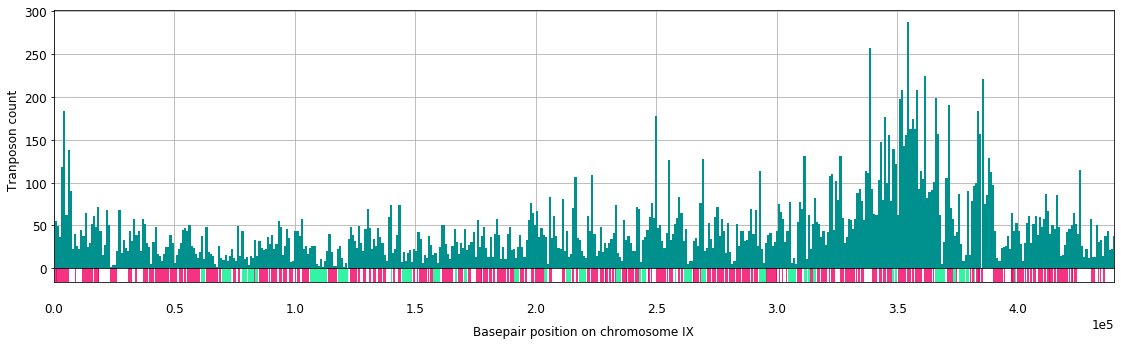

In [8]:
    print('Plotting chromosome ', chrom, '...')
    print('bar width for plotting is ',bar_width)
    
    textsize = 12
    textcolor = "#000000"

    plt.figure(figsize=(19,5))
    grid = plt.GridSpec(20, 1, wspace=0.0, hspace=0.0)
    
    binsize = bar_width
    ax = plt.subplot(grid[0:19,0])

    ax.bar(allinsertionsites_list,alltransposoncounts_binnedlist,width=binsize,color="#00918f")
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.set_axisbelow(True)
    ax.grid(True)
    ax.set_xlim(0,chr_length_dict.get(chrom))
    ax.tick_params(axis='x', which='major', pad=30)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax.xaxis.get_offset_text().set_fontsize(textsize)
    ax.set_xlabel("Basepair position on chromosome "+chrom, fontsize=textsize, color=textcolor, labelpad=10)
    ax.set_ylabel('Tranposon count', fontsize=textsize, color=textcolor)
#    ax.set_title('Transposon profile for chromosome '+chrom)


    axc = plt.subplot(grid[19,0])
    for gene in genes_currentchrom_pos_list:
        gene_start_pos = int(gene_pos_dict.get(gene)[1])
        gene_end_pos = int(gene_pos_dict.get(gene)[2])
        if gene in genes_essential_list:
            axc.axvspan(gene_start_pos,gene_end_pos,facecolor="#00F28E",alpha=0.8)
        else:
            axc.axvspan(gene_start_pos,gene_end_pos,facecolor="#F20064",alpha=0.8)    
    axc.set_xlim(0,chr_length_dict.get(chrom))
    axc.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    axc.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        labelleft=False)   # labels along the bottom edge are off

    plt.show()

## The python script for the reads profile plot
This function creates a bar plot with the number of transposons in a chromosome. The graph is annotated with the location of the genes which is colorcoded to distinquish between essential and non essential genes. Green regions indicate annotated essential genes and red regions are the genes not annotated as essential. The names of the essential genes are given as well.

This graph can be used to check how well the reads data corresponds with the location of essential genes, where only few transposon insertions are expected.

The code for the reads is similar to that for the transposons profile plot.
Import the same packages that are given above.

In [9]:
wig_file = os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing','Cerevisiae_WT2_Michel2017_trimmed1.bam.wig') #CHANGE THIS TO ANY .BED FILE YOU WANT TO ANALYSE.

### Loading additional files

In [12]:
gff_file = os.path.join(file_dirname,'Data_Files','Saccharomyces_cerevisiae.R64-1-1.99.gff3')
essential_genes_files = [os.path.join(file_dirname,'Data_Files','Cerevisiae_EssentialGenes_List_1.txt'),
                        os.path.join(file_dirname,'Data_Files','Cerevisiae_EssentialGenes_List_2.txt')]
gene_information_file = os.path.join(file_dirname,'Data_Files','Yeast_Protein_Names.txt')

### Get genes in chromosome

In [13]:
chr_length_dict, chr_start_pos_dict, chr_end_pos_dict = chromosome_position(gff_file)

arabic_to_roman_dict, roman_to_arabic_dict = chromosomename_roman_to_arabic()    
chromosomenames_list = []
for roman in roman_to_arabic_dict:
    chromosomenames_list.append(roman)


chrom_index = chromosomenames_list.index(chrom)
print('Chromosome length: ',chr_length_dict.get(chrom))
if bar_width == None:
    bar_width = int(chr_length_dict.get(chrom)/500)


gene_pos_dict = gene_position(gff_file)
genes_currentchrom_pos_list = [k for k, v in gene_pos_dict.items() if chrom in v]
genes_essential_list = list_known_essentials(essential_genes_files)
gene_alias_list = gene_aliases(gene_information_file)[0]

Chromosome length:  439888
Reading file : c:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cerevisiae_EssentialGenes_List_1.txt
Reading file : c:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cerevisiae_EssentialGenes_List_2.txt


### Read wig file

In [14]:
with open(wig_file) as f:
    lines = f.readlines()

chrom_names_dict, chrom_start_line_dict, chrom_end_line_dict = chromosome_name_wigfile(lines)

wigfile_start_index = chrom_start_line_dict.get(chrom)
wigfile_end_index = chrom_end_line_dict.get(chrom)

allreadscounts_list = np.zeros(chr_length_dict.get(chrom))
for line in lines[wigfile_start_index:wigfile_end_index]:
    line = line.strip(' \n').split()
    allreadscounts_list[int(line[0])] = int(line[1])

### Binning

In [15]:
allreadscounts_binnedlist = []
val_counter = 0
sum_values = 0
if bar_width == 1:
    allreadscounts_binnedlist = allreadscounts_list
    allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/float(bar_width)))
else:
    for n in range(len(allreadscounts_list)):
        if val_counter % bar_width != 0:
            sum_values += allreadscounts_list[n]
        elif val_counter % bar_width == 0:
            allreadscounts_binnedlist.append(sum_values)
            sum_values = 0
        val_counter += 1
        
    allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/bar_width)+1)

### Plotting
Note that the y-scale is logarithmic.

Plotting chromosome  IX ...
bar width for plotting is  879


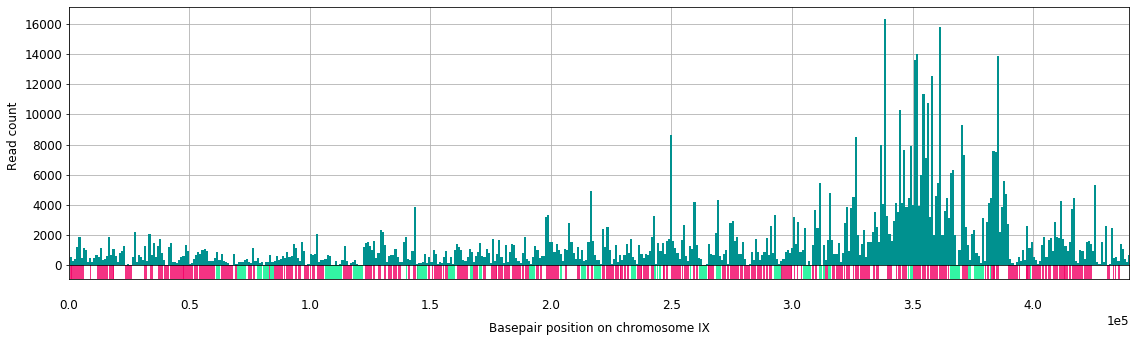

In [16]:
print('Plotting chromosome ', chrom, '...')
print('bar width for plotting is ',bar_width)

textsize = 12
textcolor = "#000000"

plt.figure(figsize=(19,5))
grid = plt.GridSpec(20, 1, wspace=0.0, hspace=0.0)

binsize = bar_width
ax = plt.subplot(grid[0:19,0])

ax.bar(allinsertionsites_list,allreadscounts_binnedlist,width=binsize,color="#00918f")
ax.tick_params(axis='both', which='major', labelsize=textsize)
ax.set_axisbelow(True)
ax.grid(True)
ax.set_xlim(0,chr_length_dict.get(chrom))
#    ax.set_yscale('log')
ax.tick_params(axis='x', which='major', pad=30)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.xaxis.get_offset_text().set_fontsize(textsize)
ax.set_xlabel("Basepair position on chromosome "+chrom, fontsize=textsize, color=textcolor, labelpad=10)
ax.set_ylabel('Read count', fontsize=textsize, color=textcolor)

axc = plt.subplot(grid[19,0])
for gene in genes_currentchrom_pos_list:
    gene_start_pos = int(gene_pos_dict.get(gene)[1])
    gene_end_pos = int(gene_pos_dict.get(gene)[2])
    if gene in genes_essential_list:
        axc.axvspan(gene_start_pos,gene_end_pos,facecolor="#00F28E",alpha=0.8)
    else:
        axc.axvspan(gene_start_pos,gene_end_pos,facecolor="#F20064",alpha=0.8)    
axc.set_xlim(0,chr_length_dict.get(chrom))
axc.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axc.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False)   # labels along the bottom edge are off

plt.show()

## Interpretation

The bar plots indicate areas of high and low insertion densities and how many reads the transposons in each region have.
Ideally the essential regions should be free of transposons and/or have few reads. The other parts of the chromosome should then have transposon insertions combined with relatively many reads. However, it might occur that transposons are present in the essential regions or that regions not annotated as essential have little or no insertions, as was noted in the introduction. Also it is also not always clear which genes are essential or not. Sometimes genes are assigned essential by one study, but not by another, hence its essentiality might be dubious. This can occur due to differences in experimental conditions or strains used. It is good to be aware of this when interpreting these or similar results.

## Bibliography
- Michel, A. H., Hatakeyama, R., Kimmig, P., Arter, M., Peter, M., Matos, J., ... & Kornmann, B. (2017). Functional mapping of yeast genomes by saturated transposition. Elife, 6, e23570.
- Segal, E. S., Gritsenko, V., Levitan, A., Yadav, B., Dror, N., Steenwyk, J. L., ... & Kunze, R. (2018). Gene essentiality analyzed by in vivo transposon mutagenesis and machine learning in a stable haploid isolate of Candida albicans. MBio, 9(5), e02048-18.